# import func

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class OLD:
    @staticmethod
    def normpdf(x, mean, sd=1):
        var = float(sd) ** 2
        pi = 3.1415926
        denom = (2 * pi * var) ** .5
        num = math.exp(-(float(x) - float(mean)) ** 2 / (2 * var))
        return num / denom

    @staticmethod
    def similarity(onset_prob, score_onset):
        sim = float(min(onset_prob, score_onset) + 1e-6) / (max(onset_prob, score_onset) + 1e-6)
        return sim

    @staticmethod
    def compute_f_I_given_D(fsource, f_I_J_given_D, cur_pos, scoreLen, window_size=200):  # 200
        left = max(0, cur_pos - window_size)
        right = min(scoreLen, cur_pos + window_size)
        f_I_given_D = np.zeros(scoreLen)
        fsource_w = fsource[left:right]
        f_I_J_given_D_w = f_I_J_given_D[:right - left]
        f_I_given_D_w = np.convolve(fsource_w, f_I_J_given_D_w)
        f_I_given_D_w = f_I_given_D_w / sum(f_I_given_D_w)
        if left + len(f_I_given_D_w) > scoreLen:
            end = scoreLen
        else:
            end = left + len(f_I_given_D_w)
        f_I_given_D[left:end] = f_I_given_D_w[:(end - left)]
        # plt.plot(f_I_given_D[:50])
        # plt.show()
        # plt.plot(fsource[:50])
        # plt.show()
        return f_I_given_D

    @staticmethod
    def compute_f_I_J_given_D(score_axis, estimated_tempo, elapsed_time, beta, alpha, Rc, no_move_flag):
        # if no_move_flag:
        #     print('no move')
        if estimated_tempo > 0:
            rateRatio = float(Rc) / float(estimated_tempo)
        else:
            rateRatio = Rc / 0.00001
        rateRatio = 1 / rateRatio
        sigmaSquare = math.log(float(1) / float(alpha * elapsed_time) + 1)
        sigma = math.sqrt(sigmaSquare)
        tmp1 = 1 / (score_axis * sigma * math.sqrt(2 * math.pi))
        tmp2 = (np.log(score_axis) - math.log(rateRatio * elapsed_time) + beta * sigmaSquare)
        tmp2 = np.exp(-tmp2 * tmp2 / (2 * sigmaSquare))
        distribution = tmp1 * tmp2
        distribution[score_axis <= 0] = 0

        distribution = distribution / sum(distribution)
        # for debug
        # plt.plot(distribution[:15])
        # plt.show()
        return distribution

    @staticmethod
    def compute_f_V_given_I(pitch, pitches, scoreLen, score_midi, onset_prob, score_onsets, alpha, w1, w2, w3, cur_pos,
                            std=1, WINSIZE=1, WEIGHT=[0.5]):
        # weight = 0.5 original
        # method2: diff with previous 5 pitches weighted as 0.1
        # WINSIZE = 5
        # WEIGHT = [0.1,0.1,0.1,0.1,0.1]
        reverse_judge = False
        f_V_given_I = np.zeros(scoreLen)
        sims = np.zeros(scoreLen)
        if pitch == -1:
            pitch = -1
        elif len(pitches) > WINSIZE:
            if pitch > 11.5:
                pitch_reverse = pitch - 12
                pitch_reverse = pitch_reverse - np.dot(pitches[-1 - WINSIZE:-1], WEIGHT)
                reverse_judge = True
            elif 0 < pitch < 0.5:
                pitch_reverse = pitch + 12
                pitch_reverse = pitch_reverse - np.dot(pitches[-1 - WINSIZE:-1], WEIGHT)
                reverse_judge = True
            pitch = pitch - np.dot(pitches[-1 - WINSIZE:-1], WEIGHT)

        # to check for two tempo at most per pitch
        # each i represent 0.01s
        window_size = 200  # 200
        left = max(0, cur_pos - window_size)
        right = min(scoreLen, cur_pos + window_size)

        for i in range(left, right):
            if score_midi[i] == -1:
                score_pitch = score_midi[i]
            # assert(score_midi[i] == -1,'fail with -1-1')
            # assert('fail with -1')
            # print('------------------------------------------1-1-1-1-1-1-')
            elif i >= WINSIZE:
                score_pitch = score_midi[i] - np.dot(score_midi[i - WINSIZE:i], WEIGHT)
            else:
                score_pitch = score_midi[i]
            score_onset = score_onsets[i]
            if pitch == -1:
                if score_pitch == -1:
                    f_V_given_I[i] = 0.1
                else:
                    f_V_given_I[i] = 0.00000000001
            elif score_pitch == -1:
                f_V_given_I[i] = 0.00000000001
            else:
                if reverse_judge and abs(pitch - score_pitch) > abs(pitch_reverse - score_pitch):
                    pitch = pitch_reverse
                f_V_given_I[i] = math.pow(
                    math.pow(OLD.normpdf(pitch, score_pitch, std), w1) * math.pow(
                        OLD.similarity(onset_prob, score_onset), w2), w3)

        return f_V_given_I

In [3]:
class NEW:
    @staticmethod
    def normalize(array):
        return np.true_divide(array, np.sum(array))

    @staticmethod
    def norm_pdf(x, mean, sd=1):
        var = sd ** 2
        denom = (2 * math.pi * var) ** 0.5
        num = math.exp(-(x - mean) ** 2 / (2 * var))
        return num / denom

    @staticmethod
    def similarity(left, right):
        return (min(left, right) + 1e-6) / (max(left, right) + 1e-6)

    @staticmethod
    def gate_mask(array, center, half_size):
        left_index = max(0, center - half_size)
        right_index = min(center + half_size, len(array))
        array[:left_index] = 0
        array[right_index:] = 0
        return array

    @staticmethod
    def compute_f_i_j_given_d(time_axis, d, score_tempo, estimated_tempo):
        # rate_ratio = estimated_tempo / score_tempo if estimated_tempo > 0 else score_tempo / 1e-5
        sigma_square = math.log(1 / (10 * d) + 1)
        sigma = math.sqrt(sigma_square)
        mu = math.log(d * RR) + sigma ** 2
        a = np.true_divide(1, np.multiply(time_axis, sigma * math.sqrt(2 * math.pi)), where=time_axis != 0)
        a[0] = 0
        # b = np.add(np.log(time_axis, where=time_axis != 0), 0.5 * sigma_square - math.log(rate_ratio * d))
        b = np.add(np.log(time_axis, where=time_axis != 0), mu)
        b = np.exp(np.true_divide(-np.square(b), 2 * sigma_square))
        b[0] = 0
        f_i_j_given_d = np.multiply(a, b)
        # remove the possible np.nan element in the beginning, otherwise normalization will fail
        f_i_j_given_d[time_axis == 0] = 0
        f_i_j_given_d = NEW.normalize(f_i_j_given_d)
        return f_i_j_given_d

    @staticmethod
    def compute_f_i_given_d(f_source, f_i_j_given_d, cur_pos, axis_length):
        # avoid overflow
        left = max(0, cur_pos - 200)  # CHANGED
        right = min(cur_pos + 200, axis_length)  # CHANGED
        f_i_given_d = np.zeros(axis_length)
        f_source_w = f_source[left:right]
        f_i_j_given_d_w = f_i_j_given_d[:right - left]
        f_i_given_d_w = np.convolve(f_source_w, f_i_j_given_d_w)
        f_i_given_d_w = f_i_given_d_w[:right - left]  # slice to window size
        f_i_given_d[left:right] = f_i_given_d_w
        f_i_given_d = NEW.normalize(f_i_given_d)
        return f_i_given_d

    @staticmethod
    def compute_f_v_given_i(pitch_axis, onset_axis, cur_pos, axis_length, audio_pitch, audio_onset, pitch_proc, w):
        f_v_given_i = np.zeros(axis_length)
        left = max(0, cur_pos - 200)
        right = min(cur_pos + 200, axis_length)
        for i in range(left, right):
            if audio_pitch == -1:
                # performance side makes no sound
                if pitch_axis[i] == -1:
                    # score side also makes no sound
                    f_v_given_i[i] = 0.1
                else:
                    # score side makes sound
                    f_v_given_i[i] = 1e-11
            else:
                # performance side makes sound
                if pitch_axis[i] == -1:
                    # score side makes no sound
                    f_v_given_i[i] = 1e-11
                else:
                    # score side also makes sound
                    f_v_given_i[i] = math.pow(
                        math.pow(NEW.norm_pdf(pitch_proc.result(pitch_axis[i]), pitch_axis[i], 1), w[0])
                        * math.pow(NEW.similarity(audio_onset, onset_axis[i]), w[1]),
                        w[2]
                    )
        f_v_given_i = NEW.normalize(f_v_given_i)
        return f_v_given_i

# useful constants

In [4]:
"""useful constants"""
param_original = {'marker': 'o', 'alpha': 0.75, 'color': 'blue', 'label': 'Original'}
param_rewritten = {'marker': 'o', 'alpha': 0.75, 'color': 'green', 'label': 'Rewritten'}
param_offset = {'marker': 'o', 'alpha': 0.75, 'color': 'red', 'label': 'Offset'}
alpha = 10
beta = 0.5
offset_range = 1E-8
chunk = 1024
sr = 44100
chunk_dur = chunk / sr
resolution = chunk_dur / 50
print('chunk_dur', chunk_dur)

chunk_dur 0.023219954648526078


# similarity

In [5]:
"""test similarity"""
print(OLD.similarity(1, 0.5))
print(NEW.similarity(1, 0.5))

0.5000004999995
0.5000004999995


# norm pdf

In [6]:
"""test norm pdf"""
def test_norm_pdf(ctr, rng, num_pts):
    x = np.linspace(ctr - rng / 2, ctr + rng / 2, num_pts)
    y1 = [OLD.normpdf(x=x, mean=ctr, sd=1) for x in x]
    y2 = [NEW.norm_pdf(x=x, mean=ctr, sd=1) for x in x]
    plt.subplot(311)
    print('norm pdf')
    print('center:', ctr)
    print('variation:', rng / 2)
    print('# of plotting points:', num_pts)
    plt.title('norm pdf')
    plt.plot(x, np.array(y1), **param_original)
    plt.ylim([0, 1])
    plt.legend()
    plt.subplot(312)
    plt.plot(x, np.array(y2), **param_rewritten)
    plt.ylim([0, 1])
    plt.legend()
    plt.subplot(313)
    plt.plot(x, np.array(y1) - np.array(y2), **param_offset)
    plt.ylim([-offset_range, offset_range])
    plt.legend()
    plt.tight_layout()
    plt.show()
    print('max offset:', np.max(np.array(y1) - np.array(y2)))

norm pdf
center: 0
variation: 5.0
# of plotting points: 100


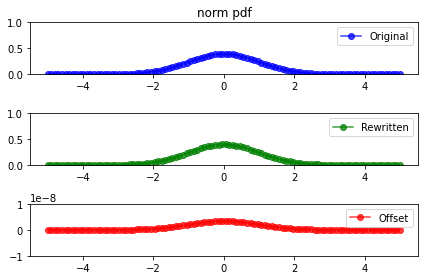

max offset: 3.3982739400251205e-09


In [7]:
test_norm_pdf(0, 10, 100)

# $f(I-J|D)$

In [8]:
"""test f i j given d"""
def test_f_i_j_given_d(time_axis, score_tempo, estimated_tempo, elapsed_time, trunc):
    old_val_1 = OLD.compute_f_I_J_given_D(score_axis=time_axis,
                                          estimated_tempo=estimated_tempo,
                                          elapsed_time=elapsed_time,
                                          beta=beta,
                                          alpha=alpha,
                                          Rc=score_tempo,
                                          no_move_flag=False)
    new_val_1 = NEW.compute_f_i_j_given_d(time_axis=time_axis,
                                          d=elapsed_time,
                                          score_tempo=score_tempo,
                                          estimated_tempo=estimated_tempo)
    plt.subplot(311)
    plt.title('$f(I-J|D)$')
    plt.plot(time_axis, np.array(old_val_1), **param_original)
    expected_time = elapsed_time * estimated_tempo / score_tempo
    actual_time = time_axis[np.argmax(old_val_1)]
    print('f i j given d')
    print('old')
    print('expected peak:', expected_time)
    print('actual peak:', actual_time)
    print('offset:', actual_time - expected_time)
    plt.vlines(actual_time, 0, 1, color='blue', label='Act Pos')
    plt.vlines(expected_time, 0, 1, color='red', label='Ref Pos')
    plt.xlim([0, trunc])
    plt.ylim([0, np.max(old_val_1)])
#     plt.legend()
    plt.subplot(312)
    plt.plot(time_axis, np.array(new_val_1), **param_rewritten)
    expected_time = elapsed_time * estimated_tempo / score_tempo
    actual_time = time_axis[np.argmax(new_val_1)]
    print('new')
    print('expected peak:', expected_time)
    print('actual peak:', actual_time)
    print('offset:', actual_time - expected_time)
    plt.vlines(actual_time, 0, 1, color='blue', label='Act Pos')
    plt.vlines(expected_time, 0, 1, color='red', label='Ref Pos')
    plt.xlim([0, trunc])
    plt.ylim([0, np.max(new_val_1)])
#     plt.legend()
    plt.subplot(313)
    offset = np.array(old_val_1) - np.array(new_val_1)
    plt.plot(time_axis, offset, **param_offset)
    plt.xlim([0, trunc])
    plt.ylim([np.min(offset), np.max(offset)])
    plt.legend()
    plt.tight_layout()
    plt.show()

f i j given d
old
expected peak: 0.023219954648526078
actual peak: 0.0018575963718820863
offset: -0.02136235827664399
new
expected peak: 0.023219954648526078
actual peak: 1.5292662131519275
offset: 1.5060462585034013


c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


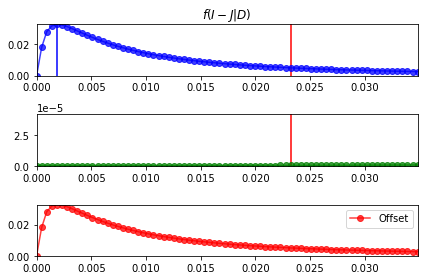

In [9]:
test_f_i_j_given_d(time_axis=np.arange(0, 100, resolution),
                   score_tempo=60,
                   estimated_tempo=60,
                   elapsed_time=chunk_dur,
                   trunc=chunk_dur * 1.5)

c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


f i j given d
old
expected peak: 0.046439909297052155
actual peak: 0.0037151927437641726
offset: -0.04272471655328798
new
expected peak: 0.046439909297052155
actual peak: 1.5292662131519275
offset: 1.4828263038548752


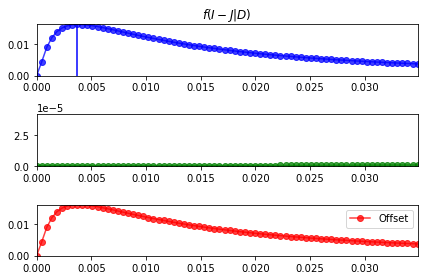

In [10]:
test_f_i_j_given_d(time_axis=np.arange(0, 100, resolution),
                   score_tempo=60,
                   estimated_tempo=120,
                   elapsed_time=chunk_dur,
                   trunc=chunk_dur * 1.5)

c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
c:\users\tomzh\miniconda3\envs\auto-accompaniment\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


f i j given d
old
expected peak: 0.011609977324263039
actual peak: 0.0009287981859410432
offset: -0.010681179138321995
new
expected peak: 0.011609977324263039
actual peak: 1.5292662131519275
offset: 1.5176562358276644


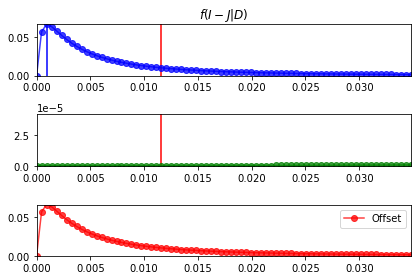

In [11]:
test_f_i_j_given_d(time_axis=np.arange(0, 100, resolution),
                   score_tempo=60,
                   estimated_tempo=30,
                   elapsed_time=chunk_dur,
                   trunc=chunk_dur * 1.5)

In [12]:
def f_i_j_given_d_offset(time_axis, score_tempo, estimated_tempo, elapsed_time):
    new_val_1 = NEW.compute_f_i_j_given_d(time_axis=time_axis,
                                          d=elapsed_time,
                                          score_tempo=score_tempo,
                                          estimated_tempo=estimated_tempo)
    expected_time = elapsed_time * estimated_tempo / score_tempo
    actual_time = time_axis[np.argmax(new_val_1)]
    return actual_time, expected_time

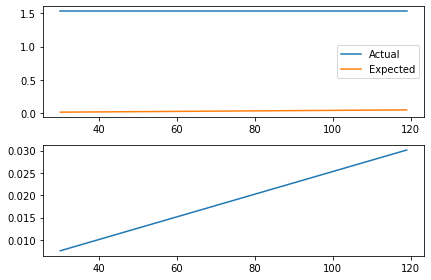

In [13]:
acts = []
exps = []
tempos = np.arange(30, 120)
for tempo in tempos:
    act, exp = f_i_j_given_d_offset(time_axis=np.arange(0, 100, resolution),
                                    score_tempo=60,
                                    estimated_tempo=tempo,
                                    elapsed_time=chunk_dur)
    acts.append(act)
    exps.append(exp)
plt.subplot(211)
plt.plot(tempos, acts, label='Actual')
plt.plot(tempos, exps, label='Expected')
plt.legend()
plt.subplot(212)
ratio = np.array(exps) / np.array(acts)
plt.plot(tempos, ratio)
# plt.hlines(ratio / len(ratio), np.min(tempos), np.max(tempos))
plt.tight_layout()
plt.show()

# $f(I|D)$

In [14]:
"""test f i given d"""
def test_f_i_given_d(time_axis, f_src, ij_d, cur_pos, scr_len, trunc):
    print('f_ij_d peak:', time_axis[np.argmax(ij_d)])
    old_val_1 = OLD.compute_f_I_given_D(fsource=f_src, f_I_J_given_D=ij_d, cur_pos=cur_pos, scoreLen=scr_len)
    new_val_1 = NEW.compute_f_i_given_d(f_source=f_src, f_i_j_given_d=ij_d, cur_pos=cur_pos, axis_length=scr_len)
    plt.subplot(311)
    plt.title('$f(I|D)$')
    plt.plot(time_axis, np.array(old_val_1), **param_original)
#     expected_time = elapsed_time * estimated_tempo / score_tempo
    actual_time = time_axis[np.argmax(old_val_1)]
    print('f i given d')
    print('old')
#     print('expected peak:', expected_time)
    print('actual peak:', actual_time)
#     print('offset:', actual_time - expected_time)
    plt.vlines(actual_time, 0, 1, color='blue', label='Act Pos')
#     plt.vlines(expected_time, 0, 1, color='red', label='Ref Pos')
    plt.xlim([0, trunc])
    plt.ylim([0, np.max(old_val_1)])
    plt.legend()
    plt.subplot(312)
    plt.plot(time_axis, np.array(new_val_1), **param_rewritten)
#     expected_time = elapsed_time * estimated_tempo / score_tempo
    actual_time = time_axis[np.argmax(new_val_1)]
    print('new')
#     print('expected peak:', expected_time)
    print('actual peak:', actual_time)
#     print('offset:', actual_time - expected_time)
    plt.vlines(actual_time, 0, 1, color='blue', label='Act Pos')
#     plt.vlines(expected_time, 0, 1, color='red', label='Ref Pos')
    plt.xlim([0, trunc])
    plt.ylim([0, np.max(new_val_1)])
    plt.legend()
    plt.subplot(313)
    offset = np.array(old_val_1) - np.array(new_val_1)
    plt.plot(time_axis, offset, **param_offset)
    plt.xlim([0, trunc])
    plt.ylim([np.min(offset), np.max(offset)])
    plt.legend()
    plt.tight_layout()
    plt.show()
    return old_val_1, new_val_1

f_ij_d peak: 1.5292662131519275
f i given d
old
actual peak: 0.0924154195011338
new
actual peak: 0.0924154195011338


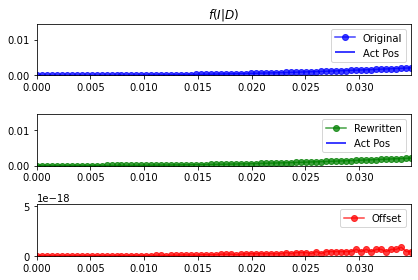

In [15]:
time_axis = np.arange(0, 10, resolution)
f_src = np.zeros((len(time_axis),))
f_src[0] = 1
ij_d = NEW.compute_f_i_j_given_d(time_axis=time_axis,
                                 d=chunk_dur,
                                 score_tempo=60,
                                 estimated_tempo=60)
cur_pos = 0
scr_len = len(time_axis)
old_fsrc, new_fsrc = test_f_i_given_d(time_axis=time_axis,
                                      f_src=f_src,
                                      ij_d=ij_d,
                                      cur_pos=cur_pos,
                                      scr_len=scr_len,
                                      trunc=chunk_dur * 1.5)

f_ij_d peak: 1.5292662131519275
f i given d
old
actual peak: 0.14907210884353742
new
actual peak: 0.0924154195011338


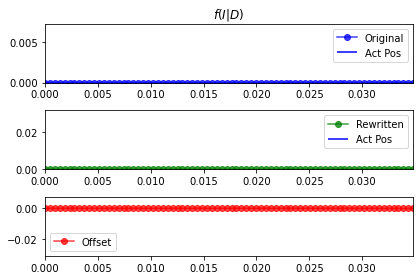

In [16]:
time_axis = np.arange(0, 10, resolution)
f_src = old_fsrc
ij_d = NEW.compute_f_i_j_given_d(time_axis=time_axis,
                                 d=chunk_dur,
                                 score_tempo=60,
                                 estimated_tempo=60)
cur_pos = 0
scr_len = len(time_axis)
_, _ = test_f_i_given_d(time_axis=time_axis,
                 f_src=f_src,
                 ij_d=ij_d,
                 cur_pos=cur_pos,
                 scr_len=scr_len,
                 trunc=chunk_dur * 1.5)

To conclude, the $f(I-J|D)$ function "pushes" the progress too slowly.

Despite it, the $f(I|D)$ function still "goes" forward too quickly.

# bypass f_i_given_d and do convolution externally

In [17]:
time_axis = np.arange(0, 10, resolution)
ij_d = NEW.compute_f_i_j_given_d(time_axis=time_axis,
                                 d=chunk_dur,
                                 score_tempo=60,
                                 estimated_tempo=60)
print(len(time_axis))
print(len(ij_d))
print(np.sum(ij_d))

21534
21534
0.9999999999999998


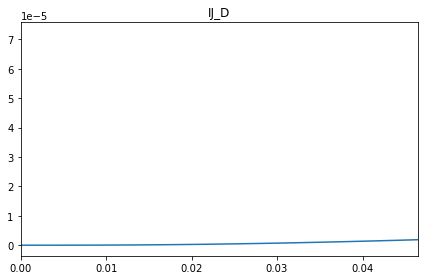

expected_gap: 1.5292662131519275


In [18]:
plt.title('IJ_D')
plt.plot(time_axis, ij_d)
plt.xlim([0, 2 * chunk_dur])
plt.tight_layout()
plt.show()
expected_gap = time_axis[np.argmax(ij_d)]
print('expected_gap:', expected_gap)

In [19]:
# prepare and init f_src
f_src = np.zeros((len(time_axis),))
f_src[0] = 1
time = 0
print('len(f_src):', len(f_src))
print('sum(f_src):', np.sum(f_src))
act_pk = time_axis[np.argmax(f_src)]
exp_pk = time * expected_gap
time += 1
print('f_src peak:', act_pk)
print('expected peak:', exp_pk)
print('peak offset:', act_pk - exp_pk)

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 0.0
expected peak: 0.0
peak offset: 0.0


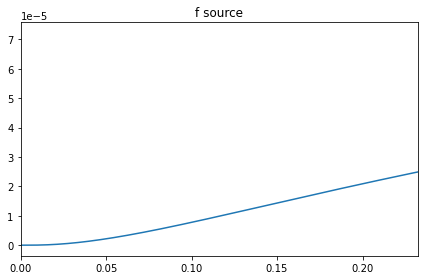

len(f_src): 21534
sum(f_src): 1.0000000000000002
f_src peak: 1.5292662131519275
expected peak: 1.5292662131519275
peak offset: 0.0


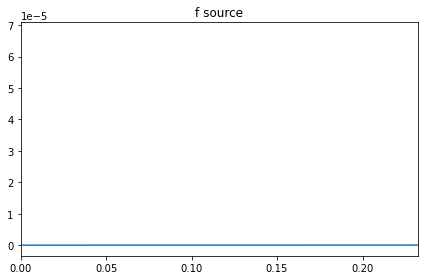

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 8.563519274376418
expected peak: 3.058532426303855
peak offset: 5.504986848072563


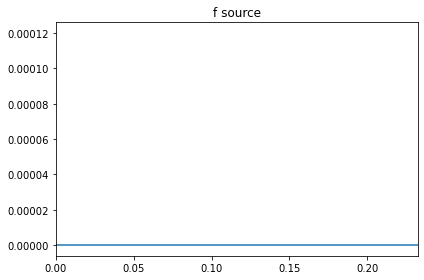

len(f_src): 21534
sum(f_src): 0.9999999999999999
f_src peak: 9.999905668934241
expected peak: 4.587798639455782
peak offset: 5.4121070294784595


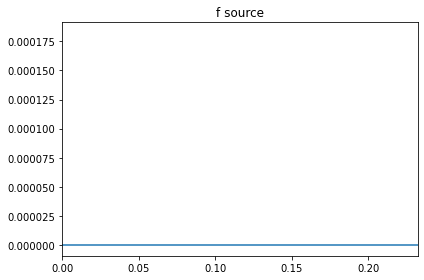

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 9.999905668934241
expected peak: 6.11706485260771
peak offset: 3.8828408163265316


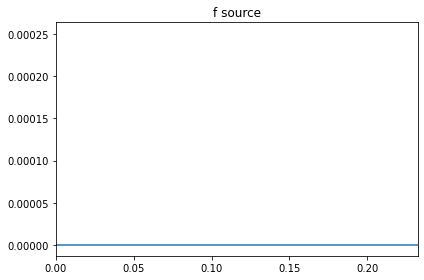

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 9.999905668934241
expected peak: 7.646331065759638
peak offset: 2.3535746031746037


In [20]:
for i in range(5):
    f_src = np.convolve(f_src, ij_d)[:len(time_axis)]
    f_src = NEW.normalize(f_src)
    plt.title('f source')
    plt.plot(time_axis, f_src)
    plt.xlim([0, 10 * chunk_dur])
    plt.tight_layout()
    plt.show()
    print('len(f_src):', len(f_src))
    print('sum(f_src):', np.sum(f_src))
    act_pk = time_axis[np.argmax(f_src)]
    exp_pk = time * expected_gap
    time += 1
    print('f_src peak:', act_pk)
    print('expected peak:', exp_pk)
    print('peak offset:', act_pk - exp_pk)

In [21]:
# prepare and init f_src
f_src = np.zeros((len(time_axis),))
f_src[0] = 1
time = 0
print('len(f_src):', len(f_src))
print('sum(f_src):', np.sum(f_src))
act_pk = time_axis[np.argmax(f_src)]
exp_pk = time * expected_gap
time += 1
print('f_src peak:', act_pk)
print('expected peak:', exp_pk)
print('peak offset:', act_pk - exp_pk)

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 0.0
expected peak: 0.0
peak offset: 0.0


In [22]:
nm_pdf = [NEW.norm_pdf(x=x, mean=expected_gap, sd=chunk_dur / 3) for x in time_axis]
nm_pdf = NEW.normalize(nm_pdf)
print(len(nm_pdf))
print(np.sum(nm_pdf))

21534
0.9999999999999999


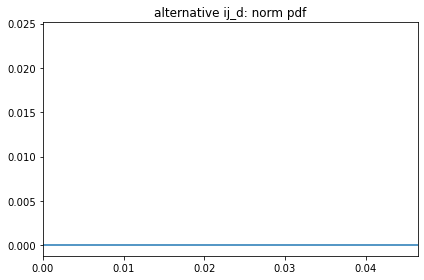

1.5292662131519275 -> 1.5292662131519275


In [23]:
plt.title('alternative ij_d: norm pdf')
plt.plot(time_axis, nm_pdf)
plt.xlim([0, chunk_dur * 2])
plt.tight_layout()
plt.show()
print(time_axis[np.argmax(nm_pdf)], '->', expected_gap)

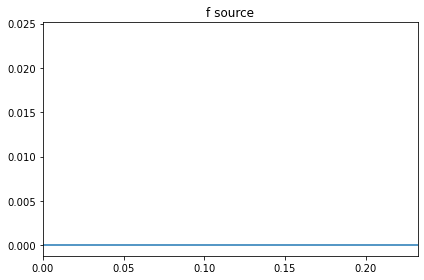

len(f_src): 21534
sum(f_src): 1.0000000000000002
f_src peak: 1.5292662131519275
expected peak: 1.5292662131519275
peak offset: 0.0


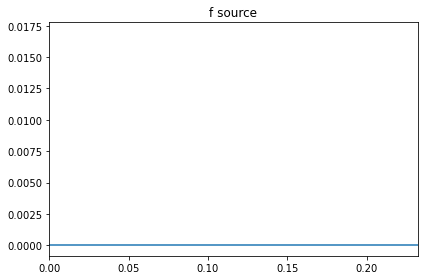

len(f_src): 21534
sum(f_src): 0.9999999999999999
f_src peak: 3.058532426303855
expected peak: 3.058532426303855
peak offset: 0.0


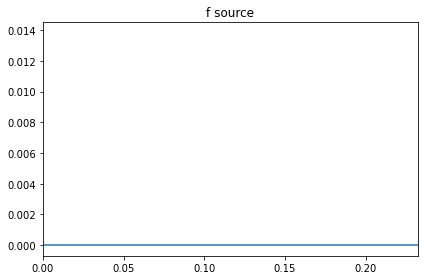

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 4.587798639455783
expected peak: 4.587798639455782
peak offset: 8.881784197001252e-16


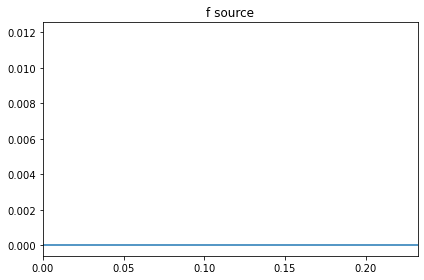

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 6.11706485260771
expected peak: 6.11706485260771
peak offset: 0.0


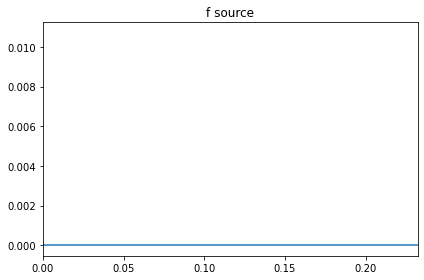

len(f_src): 21534
sum(f_src): 1.0
f_src peak: 7.646331065759638
expected peak: 7.646331065759638
peak offset: 0.0


In [24]:
for i in range(5):
    f_src = np.convolve(f_src, nm_pdf)[:len(time_axis)]
    f_src = NEW.normalize(f_src)
    plt.title('f source')
    plt.plot(time_axis, f_src)
    plt.xlim([0, 10 * chunk_dur])
    plt.tight_layout()
    plt.show()
    print('len(f_src):', len(f_src))
    print('sum(f_src):', np.sum(f_src))
    act_pk = time_axis[np.argmax(f_src)]
    exp_pk = time * expected_gap
    time += 1
    print('f_src peak:', act_pk)
    print('expected peak:', exp_pk)
    print('peak offset:', act_pk - exp_pk)

1.0000000000000002


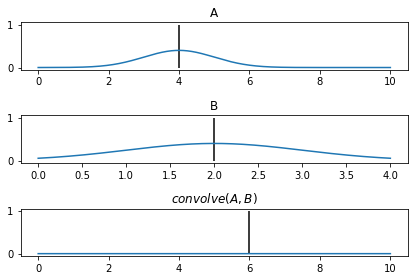

21534 8614 21534
8613
4307
12920
True


In [25]:
"""test convolution"""
x1 = np.arange(0, 10, resolution)
y1 = [NEW.norm_pdf(x=x, mean=4, sd=1) for x in x1]
plt.subplot(311)
plt.title('A')
plt.plot(x1, y1)
plt.vlines(x1[np.argmax(y1)], 0, 1)
x2 = np.arange(0, 4, resolution)
y2 = [NEW.norm_pdf(x=x, mean=2, sd=1) for x in x2]
plt.subplot(312)
plt.title('B')
plt.plot(x2, y2)
plt.vlines(x2[np.argmax(y2)], 0, 1)
result = np.convolve(y2, y1, mode='full')[:len(y1)]
result = NEW.normalize(result)
print(np.sum(result))
plt.subplot(313)
plt.title('$convolve(A,B)$')
plt.plot(x1, result)
plt.vlines(x1[np.argmax(result)], 0, 1)
plt.tight_layout()
plt.show()
print(len(y1), len(y2), len(result))
print(np.argmax(y1))
print(np.argmax(y2))
print(np.argmax(result))
print(np.argmax(y1) + np.argmax(y2) == np.argmax(result))

# Feb 1st

10000
1.0


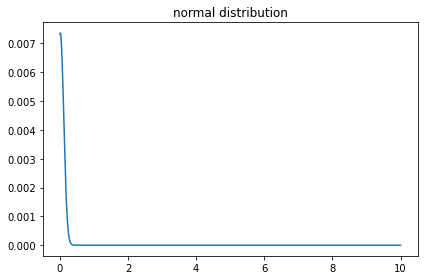

peak at 0.01


In [26]:
# generate a norm pdf curve
time_axis = np.arange(0, 10, 0.001)
nm_pdf = [NEW.norm_pdf(x=x, mean=0.01, sd=0.1) for x in time_axis]
nm_pdf = NEW.normalize(nm_pdf)
print(len(nm_pdf))
print(np.sum(nm_pdf))
plt.title('normal distribution')
plt.plot(time_axis, nm_pdf)
plt.tight_layout()
plt.show()
print('peak at', time_axis[np.argmax(nm_pdf)])

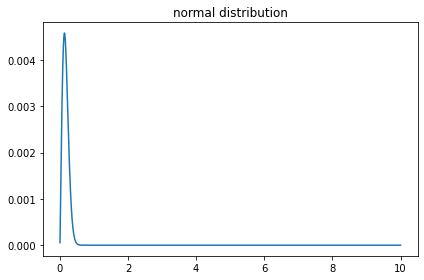

peak at 0.132


In [27]:
tmp = np.convolve(nm_pdf, nm_pdf)[:len(time_axis)]
plt.title('normal distribution')
plt.plot(time_axis, tmp)
plt.tight_layout()
plt.show()
print('peak at', time_axis[np.argmax(tmp)])

In [28]:
def manual_convolution(left, right):
    length = max(len(left), len(right))
    result = np.zeros(length)
    for i in range(len(left)):
        for j in range(len(right)):
            if i + j < length:
                result[i + j] += left[i] * right[j]
    return result        

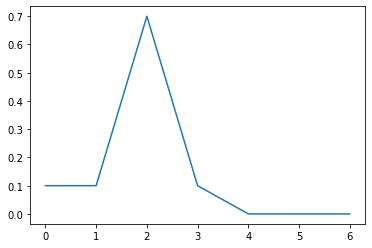

In [29]:
a = [0.1,0.1,0.7,0.1]
b = [1,0,0,0]
plt.plot(np.convolve(a,b))

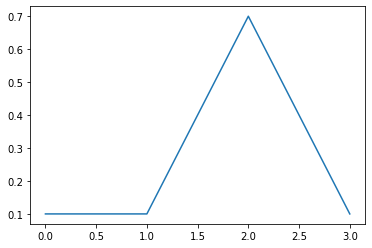

In [30]:
plt.plot(manual_convolution(a,b))

In [31]:
manual_convolution(a,b)

array([0.1, 0.1, 0.7, 0.1])

10000
0.9999999999999999


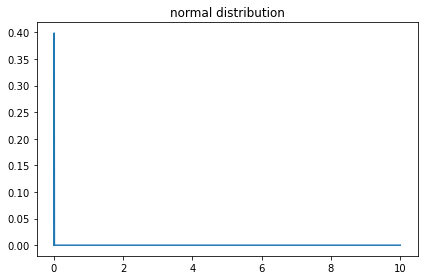

peak at 0.01


In [32]:
# generate a norm pdf curve
time_axis = np.arange(0, 10, 0.001)
nm_pdf = [NEW.norm_pdf(x=x, mean=0.01, sd=0.001) for x in time_axis]
nm_pdf = NEW.normalize(nm_pdf)
print(len(nm_pdf))
print(np.sum(nm_pdf))
plt.title('normal distribution')
plt.plot(time_axis, nm_pdf)
plt.tight_layout()
plt.show()
print('peak at', time_axis[np.argmax(nm_pdf)])

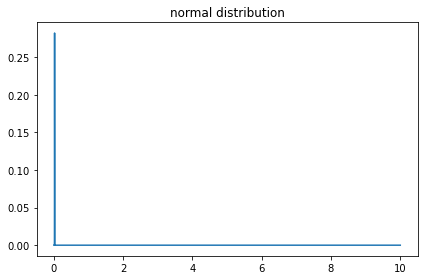

peak at 0.02


In [33]:
tmp = np.convolve(nm_pdf, nm_pdf)[:len(time_axis)]
plt.title('normal distribution')
plt.plot(time_axis, tmp)
plt.tight_layout()
plt.show()
print('peak at', time_axis[np.argmax(tmp)])

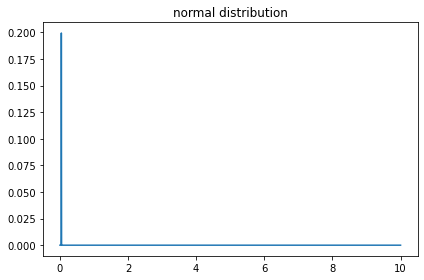

peak at 0.04


In [34]:
tmp = np.convolve(tmp, tmp)[:len(time_axis)]
plt.title('normal distribution')
plt.plot(time_axis, tmp)
plt.tight_layout()
plt.show()
print('peak at', time_axis[np.argmax(tmp)])

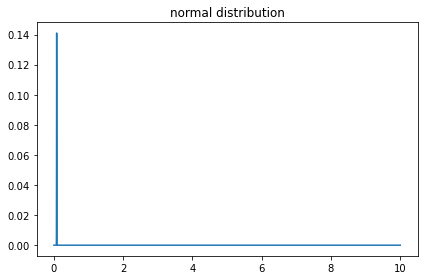

peak at 0.08


In [35]:
tmp = np.convolve(tmp, tmp)[:len(time_axis)]
plt.title('normal distribution')
plt.plot(time_axis, tmp)
plt.tight_layout()
plt.show()
print('peak at', time_axis[np.argmax(tmp)])

# test with different mask

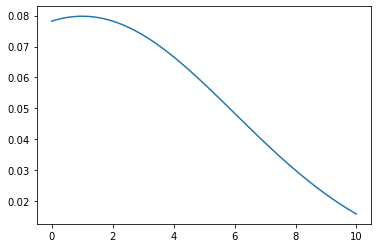

In [36]:
xax = np.arange(0, 10, 0.01)
kernel = np.array([NEW.norm_pdf(x, 1, 5) for x in xax])
plt.plot(xax, kernel)

In [37]:
xax[np.argmax(kernel)]

1.0

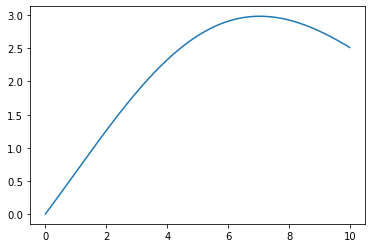

In [38]:
result = np.convolve(kernel, kernel)[:len(kernel)]
plt.plot(xax, result)

In [39]:
xax[np.argmax(result)]

7.04

In [40]:
round(4.5)

4

In [41]:
def lin_fltr(data, center, radius):
    fltr = np.zeros(len(data))
    lb = center - radius
    lws = round(center - radius * 0.5)
    rws = round(center + radius * 0.5)
    rb = center + radius
    
    partial = np.geomspace(0.001, 1., lws - lb)
    fltr[lb: lws] = partial
    fltr[lws: rws] = 1.0
    partial = np.geomspace(1., 0.001, rb - rws)
    fltr[rws: rb] = partial
    
    return data * fltr

1.0

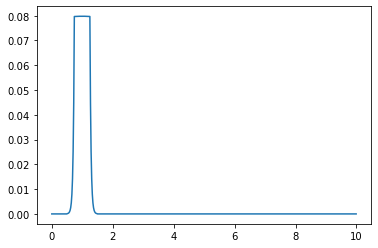

In [42]:
fkernel = lin_fltr(kernel, 100, 50)
plt.plot(xax, fkernel)
xax[np.argmax(fkernel)]

1.99

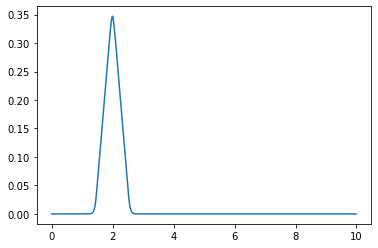

In [43]:
result = np.convolve(fkernel, fkernel)[:len(fkernel)]
plt.plot(xax, result)
xax[np.argmax(result)]

2.5

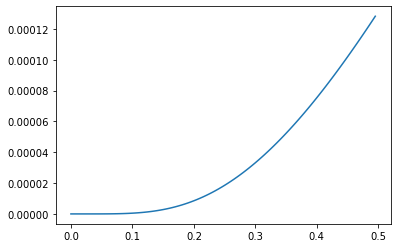

In [44]:
tax = np.arange(0, 10, 0.005)
src = np.zeros(len(tax))
src[0] = 1.

test = NEW.compute_f_i_j_given_d(tax, 0.1, 70, 70)
plt.plot(tax[:100], test[:100])
tax[np.argmax(test)]

In [45]:
test = lin_fltr(test, )

TypeError: lin_fltr() missing 2 required positional arguments: 'center' and 'radius'

In [ ]:
src = np.convolve(src, test)[:len(src)]
plt.plot(tax, src)
tax[np.argmax(src)]

In [ ]:
src = np.convolve(src, test)[:len(src)]
plt.plot(tax, src)
tax[np.argmax(src)]

# short conclusion @ 2.8

linear filter **does** work on normal distribution test cases.

but it **cannot** work on the actual $f(I-J|D)$ case, because the linear module of the beginning is too steep. perhaps that's also why the convolution tends to push forward too fast (left module is lost)

# directly delve into $f(I-J|D)$

In [ ]:
time_axis = np.arange(0, 20, 0.0001)
estimated_tempo = 60
score_tempo = 60
d = 0.05
rate_ratio = estimated_tempo / score_tempo if estimated_tempo > 0 else score_tempo / 1e-5
sigma_square = math.log(1 / (10 * d) + 1)
sigma = math.sqrt(sigma_square)

In [ ]:
a = np.true_divide(1, np.multiply(time_axis, sigma * math.sqrt(2 * math.pi)), where=time_axis != 0)

In [ ]:
plt.plot(time_axis, a)
plt.xlim([-0.1, 0.1])

In [ ]:
b = np.add(np.log(time_axis, where=time_axis != 0), 0.5 * sigma_square - math.log(rate_ratio * d))
b = np.exp(np.true_divide(-np.square(b), 2 * sigma_square))

In [ ]:
plt.plot(time_axis, b)
plt.xlim([-0.1, 0.1])

In [ ]:
f_i_j_given_d = np.multiply(a, b)
# remove the possible np.nan element in the beginning, otherwise normalization will fail
f_i_j_given_d[time_axis == 0] = 0
f_i_j_given_d = NEW.normalize(f_i_j_given_d)
plt.plot(time_axis, f_i_j_given_d)
plt.xlim([-0.2, 0.2])
time_axis[np.argmax(f_i_j_given_d)]

# March 1